In [1]:
import sys
sys.path.append('../../')

from amplify.client import FixstarsClient
import numpy as np
import os

from flow_solver.finite_element_model import FEM
from flow_solver.mesh_generator import MeshDoublePipe
from optimizer import Annealing, AnnealingSolver, PolyTop
from problems.topo_opt_level_set_fluid_flow import TopologyOptimizationProblem

# Topology Optimization for Double Pipe Problem

## Computational Mesh

In [2]:
# Create Meshes for double pipe problem.
n_elem_for_width = 48
n_elem_for_height = 32
mesh_v = MeshDoublePipe('Q2', n_elem_for_width, n_elem_for_height, width=1.5, height=1.0, inlet_height=1./6., outlet_height=1./6.)
mesh_p = MeshDoublePipe('Q1', n_elem_for_width, n_elem_for_height, width=1.5, height=1.0, inlet_height=1./6., outlet_height=1./6.)

## Finite Element Model

### Boundary Conditions

In [3]:
def upper_inlet_velocity(mesh, i_node):
    x = mesh.coords[i_node][0]; y = mesh.coords[i_node][1]
    v_x = 1-144*((y-3/4)**2); v_y = 0.0
    return np.array([v_x, v_y])

In [4]:
def lower_inlet_velocity(mesh, i_node):
    x = mesh.coords[i_node][0]; y = mesh.coords[i_node][1]
    v_x = 1-144*((y-1/4)**2); v_y = 0.0
    return np.array([v_x,v_y])

In [5]:
# Compute boundary velocities.
boundary_velocity = {key: [] for key in mesh_v.boundary_nodes.keys()}
for boundary in mesh_v.boundary_nodes.keys():
    for i_node in mesh_v.boundary_nodes[boundary]:
        if boundary == 'inlet_upper':
            boundary_velocity[boundary].append(upper_inlet_velocity(mesh_v, i_node))
        elif boundary == 'inlet_lower':
            boundary_velocity[boundary].append(lower_inlet_velocity(mesh_v, i_node))
        elif boundary == 'wall':
            boundary_velocity[boundary].append(np.zeros(2))
        if boundary == 'outlet_upper':
            boundary_velocity[boundary].append(upper_inlet_velocity(mesh_v, i_node))
        elif boundary == 'outlet_lower':
            boundary_velocity[boundary].append(lower_inlet_velocity(mesh_v, i_node))

# Set values for Dirichlet boundary conditions.
# Velocity.
BC = []
for boundary in mesh_v.boundary_nodes.keys():
    for i_node, node in enumerate(mesh_v.boundary_nodes[boundary]):
        if (boundary == 'inlet_upper' or 
            boundary == 'inlet_lower' or 
            boundary == 'wall' or 
            boundary == 'outlet_upper' or 
            boundary == 'outlet_lower'):
            BC.append([node, 0, boundary_velocity[boundary][i_node][0]])
            BC.append([node, 1, boundary_velocity[boundary][i_node][1]])
boundary_values_v = np.array(BC)

### Material Properties

In [6]:
viscosity = 1. 
density = 1.

# 
epsilon = 8.e-2

### Finite Element Model

In [7]:
fem = FEM(mesh_v, mesh_p, viscosity, density, epsilon)
fem.set_boudary_values_v(boundary_values_v)

Objective Function:0.001291177124467389


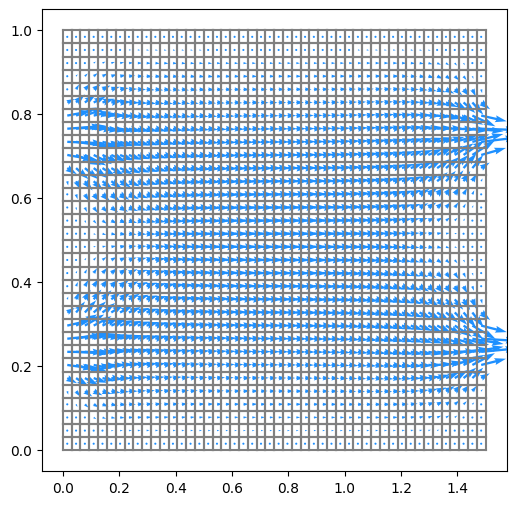

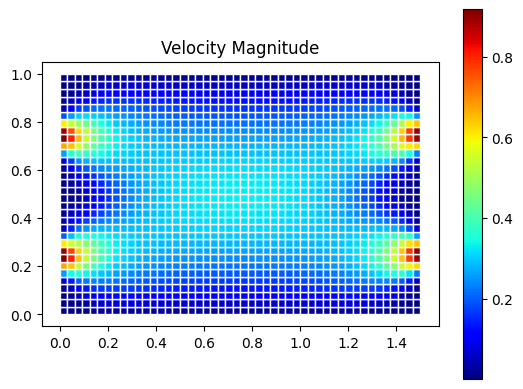

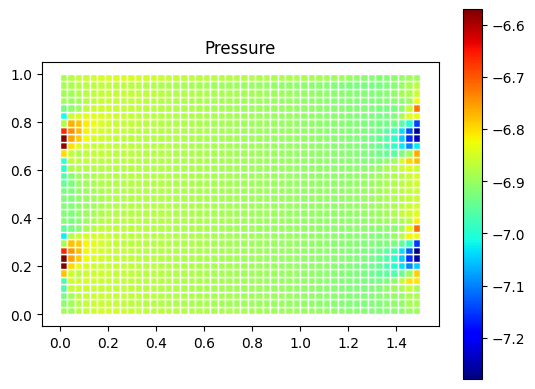

In [8]:
U, u_e, v_e, p_e, F, f=fem.solve()
print(f'Objective Function:{f}')
fem.plot_velocity_field([u_e, v_e])
fem.plot_velocity_magnitude([u_e, v_e])
fem.plot_pressure(p_e)

## Optimization

In [9]:
# Settings for Optimization.
volume_fraction_max = 1./3. # Volume fraction.
design_tolerance = 0.01 # Convergence tolerance on design variables.

active = {'classic': True,
          'annealing': True}

### Optimization with Ising Machine Formulation

In [10]:
# Annealing Solver.
client = FixstarsClient()
client.parameters.timeout = 10000
client.parameters.outputs.duplicate = True
if os.path.exists('token_Fixstars.txt'):
    client.token = open('token_Fixstars.txt',"r").read().replace('\n', '')
if os.path.exists('proxy.txt'):
    client.proxy = open('proxy.txt',"r").read().replace('\n', '')

annealing_solver = AnnealingSolver(client)

In [11]:
# Topology Optimization Problem in Ising Machine Formulation.
n_qubits_per_variable = 9

hyperparameters = {
        'energy_dissipation': 3200.,
        'regularization': 2.,
        'volume_constraint': 160.,
        'char_func': 25.
}

topo_opt_problem = TopologyOptimizationProblem(fem.ne, n_qubits_per_variable, hyperparameters, volume_fraction_max)
topo_opt_problem.generate_discretizaton()

Iteration: 0, Objective Function: 0.02128826734058361, Volume Fraction: 0.33984375, Inconsistencies: 0
Abs. change in
	char. func.:1014.0
Rel. change in
	char. func.:0.66015625
	Obj. func.: 15.487487996168634
Iteration: 1, Objective Function: 0.014764228859818946, Volume Fraction: 0.3352864583333333, Inconsistencies: 0
Abs. change in
	char. func.:41.0
Rel. change in
	char. func.:0.07854406130268199
	Obj. func.: 0.30646169443425497
Iteration: 2, Objective Function: 0.013315893651565122, Volume Fraction: 0.3346354166666667, Inconsistencies: 0
Abs. change in
	char. func.:17.0
Rel. change in
	char. func.:0.03300970873786408
	Obj. func.: 0.09809758586142542
Iteration: 3, Objective Function: 0.012673947788747853, Volume Fraction: 0.3346354166666667, Inconsistencies: 0
Abs. change in
	char. func.:10.0
Rel. change in
	char. func.:0.019455252918287938
	Obj. func.: 0.0482089959273455
Iteration: 4, Objective Function: 0.012286612632267236, Volume Fraction: 0.3346354166666667, Inconsistencies: 0
A

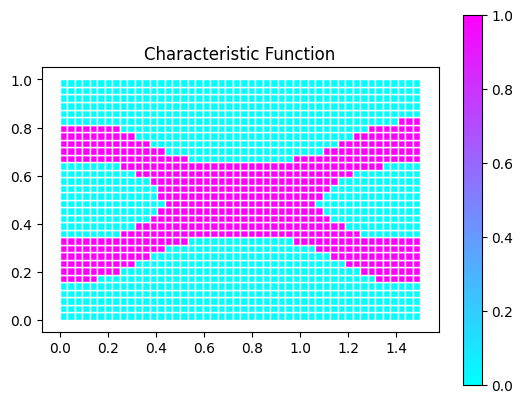

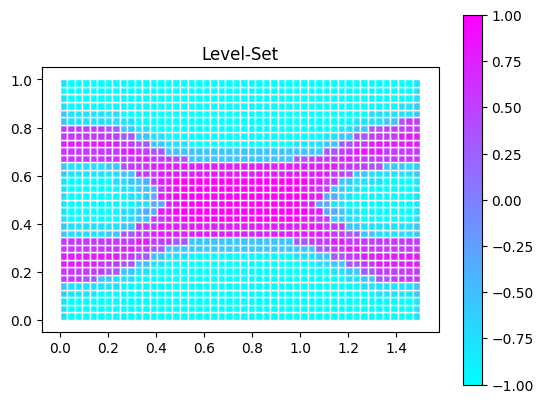

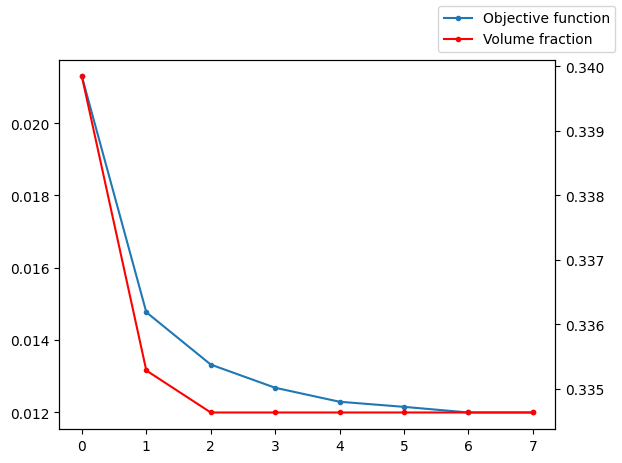

In [12]:
# Optimization
max_opt_steps = 15
# Initial scaled level-set values, i.e., design variables, for each element.
level_set_scaled_initial = np.ones(mesh_v.n_elem) 
annealing_optimizer = Annealing(fem)

annealing_optimizer.optimize(annealing_solver,
                            topo_opt_problem, 
                            level_set_scaled_initial,
                            max_opt_steps,
                            design_tolerance,
                            plot_steps=False)
annealing_optimizer.plot_history()

In [13]:
hyperparameters = {
        'energy_dissipation': 1.,
        'regularization': 0.,
        'volume_constraint': 0.05,
        'char_func': 0.
}
topo_opt_problem.set_hyperparameters(hyperparameters)

Iteration: 0, Objective Function: 0.020346737524760867, Volume Fraction: 0.33984375, Inconsistencies: 1014
Abs. change in
	char. func.:1014.0
Rel. change in
	char. func.:0.66015625
	Obj. func.: 14.758285319029257
Iteration: 1, Objective Function: 0.014870822288675, Volume Fraction: 0.3352864583333333, Inconsistencies: 1021
Abs. change in
	char. func.:39.0
Rel. change in
	char. func.:0.07471264367816093
	Obj. func.: 0.2691298902058366
Iteration: 2, Objective Function: 0.013405506524029633, Volume Fraction: 0.3346354166666667, Inconsistencies: 1022
Abs. change in
	char. func.:17.0
Rel. change in
	char. func.:0.03300970873786408
	Obj. func.: 0.09853629720000687
Iteration: 3, Objective Function: 0.012687255415105835, Volume Fraction: 0.3346354166666667, Inconsistencies: 1022
Abs. change in
	char. func.:12.0
Rel. change in
	char. func.:0.023346303501945526
	Obj. func.: 0.05357881163507841
Iteration: 4, Objective Function: 0.012229017179095612, Volume Fraction: 0.3346354166666667, Inconsiste

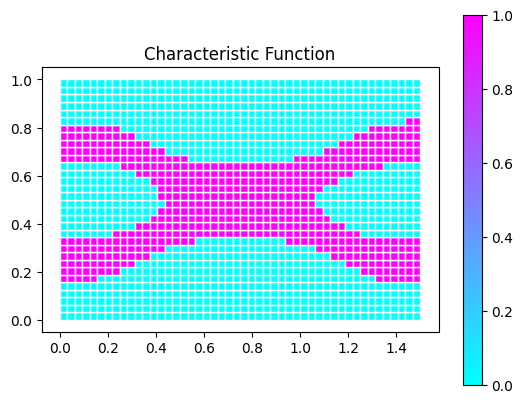

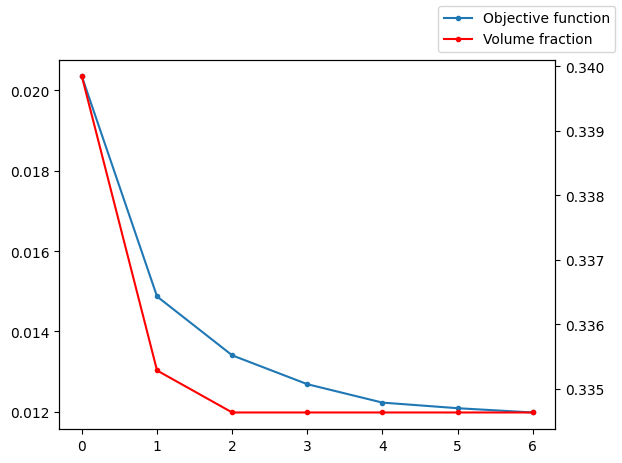

In [14]:
annealing_optimizer.optimize(annealing_solver,
                            topo_opt_problem, 
                            level_set_scaled_initial,
                            max_opt_steps,
                            design_tolerance,
                            plot_steps=False)
annealing_optimizer.plot_history()